##**Load and clean data**##

In [1]:
import os
cwd = os.getcwd()

import pandas as pd

# read excel spreadsheet into a dataframe
raw = pd.read_excel(cwd + '/MAYO-01-17VW Client Data Tables and Stats Mouse Feces.xlsx', header=None, sheet_name=1, usecols="B, N:W", skiprows=lambda x: x in [0, 1, 2, 3, 4, 6])
raw.head()

,1,13,14,15,16,17,18,19,20,21,22
0,NaN,Day 7,Week 12,Day 7,Week 12,Day 7,Week 12,Day 7,Week 12,Day 7,Week 12
1,(12 or 13)-methylmyristate (a15:0 or i15:0),127452336,398733600,194414640,205534192,190075648,368667328,363972864,177412320,261315008,267093568
2,(14 or 15)-methylpalmitate (a17:0 or i17:0),13088862,17803722,16050609,16540071,24838720,21238488,18666004,13516261,15583477,15641594
3,(16 or 17)-methylstearate (a19:0 or i19:0),1849648,1881931,1832783,2877598,3745333,3074163,2926198,1760097,1750348,2235711
4,(3'-5')-adenylyladenosine*,85744,NaN,30137,NaN,112979,174232,104255,NaN,82381,NaN


In [2]:
def clean(df):
  """
  Processes the raw excel spreadsheet dataframe with pandas. Returns cleaned dataframe
  """
  # tranpose so axis 0 is the example dimension and axis 1 is the features dimension
  transposed = df.transpose()
  transposed.reset_index(drop=True, inplace=True)

  # use first row as header
  # https://stackoverflow.com/a/31328974/14772896
  new_header = transposed.iloc[0] #grab the first row for the header
  transposed = transposed[1:] #take the data less the header row
  transposed.columns = new_header #set the header row as the df header
  transposed.reset_index(drop=True, inplace=True)

  # Make a target column based on whether or not the sample was taken in Week 12
  transposed.insert(0, 'AfterProbiotic', transposed.iloc[:, 0] == 'Week 12', allow_duplicates=False)
  transposed = transposed.loc[:, transposed.columns.notnull()]
  transposed.index.name = None
  transposed.iloc[:, 0] = transposed.iloc[:, 0].astype(int)
  return transposed.apply(pd.to_numeric)

In [3]:
cleaned = clean(raw)
cleaned.head()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,...,threonate,threonine,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose
0,0,127452336,13088862,1849648,85744.0000,34092.0,85874.0,97642.0000,31036.0,93433.0000,98221.0,NaN,34724.0,41824.0,6952495.5,3.710256e+06,420394.0,258903.0000,636876.0000,NaN,1.767055e+06,4049742.5,562854.0000,3507385.0,8301770.00,246810.0,6080374.000,12625956,931280.0,228509.0000,2441671,5683364,19908704,1.587143e+06,2210649.000,782299,376039,886376,29414322,155821552,...,67523752,288447456,4820321.0,11264001,15756378,1884308.00,9.716410e+05,1752790.75,60329608,160565888,252152.9844,25159930.0,82117184,3308909.0,2614138,155351760,1261616.0,432454,258522064,591501,1150378,660328.000,49986860,6565542.00,301052544.0,33665008.0,69467.0000,17629108,3713509,5598799.0,875583488,4538598,7908227,25505568.00,141336.0000,1.937091e+06,105549264,168667.0000,4.616876e+06,61953768.0
1,1,398733600,17803722,1881931,NaN,NaN,NaN,NaN,NaN,24328.0000,NaN,NaN,NaN,NaN,5876772.0,8.167889e+05,122128.0,158442.0000,135971.0000,2.029130e+05,4.504270e+05,1356206.0,107786.0000,NaN,6344412.50,317103.0,3717352.750,3576474,NaN,62920.0000,1167618,1899435,4774751,3.219120e+05,1532020.000,544642,165002,791602,41865080,253919760,...,11950671,147919264,1135850.0,8339046,32718874,268750.00,1.022203e+06,11657474.00,40483460,9478781,204753.0000,4254802.0,15167532,1115459.0,4720747,46235656,157247.0,564656,131025232,2543792,498656,997748.000,55208316,3032299.00,NaN,6564965.5,NaN,45081784,3678150,691263.0,390410784,809255,1905679,8003963.00,NaN,4.572610e+05,131103576,23525.0000,1.409255e+06,49363300.0
2,0,194414640,16050609,1832783,30136.9980,NaN,36636.0,45126.0000,NaN,53159.0039,35410.0,NaN,16816.0,27214.0,7356227.0,1.855772e+06,401640.0,129688.9922,217945.0000,NaN,1.160117e+06,1823760.0,430429.9688,1736091.0,4956334.00,122919.0,3057759.000,8649357,104075.0,120197.0000,2380674,4563479,8366090,7.349990e+05,1965338.875,564778,136588,538938,29752018,209019584,...,27731004,195364080,2109509.0,9351121,22206516,1182925.00,6.799360e+05,203

In [4]:
cleaned.isnull().sum().sum()

438

In [5]:
def impute(df):
  """
  Replaces each NAN element in each column with x, where x is the minimum value of the column / 2
  """
  newdf = df.copy()
  for (label, content) in df.iteritems():
    newdf[label].fillna(newdf[label].min() / 2, inplace=True)
  return newdf

In [6]:
imputed = impute(cleaned)
imputed.head()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,...,threonate,threonine,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose
0,0,127452336,13088862,1849648,85744.0000,34092.0,85874.0,97642.0000,31036.0,93433.0000,98221.0,14740.001,34724.0,41824.0,6952495.5,3.710256e+06,420394.0,258903.0000,636876.00000,1.014565e+05,1.767055e+06,4049742.5,562854.0000,3.507385e+06,8301770.00,246810.0,6080374.000,12625956,931280.0,228509.00000,2441671,5683364,19908704,1.587143e+06,2210649.000,782299,376039,886376,29414322,155821552,...,67523752,288447456,4820321.0,11264001,15756378,1884308.00,9.716410e+05,1752790.75,60329608,160565888,252152.9844,25159930.0,82117184,3308909.0,2614138,155351760,1261616.0,432454,258522064,591501,1150378,660328.000,49986860,6565542.00,301052544.0,33665008.0,69467.0000,17629108,3713509,5598799.0,875583488,4538598,7908227,25505568.00,141336.0000,1.937091e+06,105549264,168667.0000,4.616876e+06,61953768.0
1,1,398733600,17803722,1881931,15068.4990,17046.0,18318.0,22563.0000,15518.0,24328.0000,9897.0,14740.001,8408.0,13607.0,5876772.0,8.167889e+05,122128.0,158442.0000,135971.00000,2.029130e+05,4.504270e+05,1356206.0,107786.0000,4.632085e+05,6344412.50,317103.0,3717352.750,3576474,28672.5,62920.00000,1167618,1899435,4774751,3.219120e+05,1532020.000,544642,165002,791602,41865080,253919760,...,11950671,147919264,1135850.0,8339046,32718874,268750.00,1.022203e+06,11657474.00,40483460,9478781,204753.0000,4254802.0,15167532,1115459.0,4720747,46235656,157247.0,564656,131025232,2543792,498656,997748.000,55208316,3032299.00,181209.5,6564965.5,16152.5000,45081784,3678150,691263.0,390410784,809255,1905679,8003963.00,19153.0000,4.572610e+05,131103576,23525.0000,1.409255e+06,49363300.0
2,0,194414640,16050609,1832783,30136.9980,17046.0,36636.0,45126.0000,15518.0,53159.0039,35410.0,14740.001,16816.0,27214.0,7356227.0,1.855772e+06,401640.0,129688.9922,217945.00000,1.014565e+05,1.160117e+06,1823760.0,430429.9688,1.736091e+06,4956334.00,122919.0,3057759.000,8649357,104075.0,120197.00000,2380674,4563479,8366090,7.349990e+05,19653

In [7]:
imputed.isnull().sum().sum()

0

In [8]:
def scale(df):
  """
  For each column, divides each element by the sum of the elements in the column
  """
  newdf = df.copy()
  for (label, content) in df.iteritems():
    newdf[label] = newdf[label] / newdf[label].sum()
  return newdf

In [9]:
scaled = pd.concat([imputed.iloc[:, 0], scale(imputed.iloc[:, 1:])], axis=1)
scaled.head()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,...,threonate,threonine,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose
0,0,0.049890,0.075672,0.077282,0.131913,0.085587,0.114485,0.103269,0.12732,0.096575,0.172273,0.051599,0.096152,0.089285,0.074844,0.298687,0.302959,0.210394,0.428261,0.015717,0.309151,0.097773,0.281134,0.344383,0.125501,0.172106,0.159490,0.160103,0.120892,0.286657,0.186730,0.249541,0.326334,0.279168,0.146737,0.116981,0.059103,0.080356,0.103431,0.066609,...,0.123344,0.141584,0.175608,0.111959,0.062567,0.159566,0.052786,0.021425,0.102426,0.155166,0.114857,0.143434,0.118820,0.012539,0.048039,0.201704,0.202704,0.010130,0.140342,0.016433,0.089568,0.068494,0.069826,0.076946,0.148618,0.155038,0.055191,0.070227,0.064290,0.143100,0.135834,0.145017,0.148494,0.117812,0.179774,0.170055,0.065532,0.092127,0.172199,0.104916
1,1,0.156080,0.102931,0.078631,0.023182,0.042794,0.024421,0.023863,0.06366,0.025146,0.017359,0.051599,0.023282,0.029048,0.063264,0.065754,0.088012,0.128756,0.091432,0.031435,0.078803,0.032743,0.053837,0.045482,0.095911,0.221123,0.097507,0.045351,0.003722,0.078931,0.089295,0.083399,0.078266,0.056622,0.101691,0.081443,0.025934,0.071764,0.147212,0.108544,...,0.021830,0.072606,0.041380,0.082886,0.129923,0.022758,0.055533,0.142494,0.068732,0.009160,0.093266,0.024256,0.021947,0.004227,0.086750,0.060031,0.025265,0.013226,0.071129,0.070671,0.038825,0.103494,0.077120,0.035538,0.000089,0.030234,0.012833,0.179587,0.063678,0.017668,0.060567,0.025857,0.035783,0.036971,0.024362,0.040142,0.081398,0.012850,0.052562,0.083594
2,0,0.076102,0.092795,0.076577,0.046364,0.042794,0.048842,0.047727,0.06366,0.054947,0.062107,0.051599,0.046564,0.058096,0.079190,0.149395,0.289444,0.105390,0.146555,0.015717,0.202966,0.044031,0.214991,0.170463,0.074927,0.085714,0.080206,0.109678,0.013510,0.150783,0.182065,0.200370,0.137133,0.129281,0.130454,0.084454,0.021468,0.048859,0.104618,0.089350,...,0.050656,0.095894,0.076851,0.092945,0.088180,0.100172,0.036939,0.024838,0.111435,0.075424,0.078359,0.123493,0.049299,0.005338,0.023

In [10]:
scaled.describe()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,...,threonate,threonine,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.500000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
std,0.527046,0.036502,0.020608,0.029611,0.085342,0.078407,0.084289,0.085378,0.094687,0.081201,0.105129,0.097062,0.084683,0.086841,0.024509,0.078543,0.105022,0.059138,0.123073,0.190790,0.089646,0.141302,0.086937,0.096065,0.052501,0.062365,0.046460,0.050155,0.147493,0.078570,0.054940,0.070030,0.086280,0.081693,0.030072,0.029760,0.141484,0.057308,0.029002,0.026732,...,0.064433,0.063824,

In [11]:
import numpy as np

def transform(df):
  """ 
  Apply arcsine transformation on all values
  """  
  newdf = df.copy()
  newdf = np.arcsin(np.sqrt(newdf))
  return newdf

In [12]:
transformed = pd.concat([scaled.iloc[:, 0], transform(scaled.iloc[:, 1:])], axis=1)
transformed.head()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,...,threonate,threonine,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose
0,0,0.225261,0.278679,0.281707,0.371699,0.296896,0.345170,0.327160,0.364861,0.315998,0.428007,0.229154,0.315282,0.303442,0.277109,0.578206,0.582864,0.476517,0.713411,0.125700,0.589582,0.318021,0.558861,0.627153,0.362124,0.427786,0.410821,0.411657,0.355112,0.564986,0.446845,0.523068,0.608036,0.556672,0.393110,0.349071,0.245571,0.287413,0.327426,0.261043,...,0.358856,0.385775,0.432405,0.341183,0.252818,0.410924,0.231824,0.146901,0.325772,0.404882,0.345753,0.388421,0.351922,0.112215,0.220971,0.465774,0.467020,0.100817,0.383989,0.128544,0.303937,0.264798,0.267422,0.281078,0.395760,0.404706,0.237145,0.268208,0.256353,0.387943,0.377456,0.390673,0.395586,0.350361,0.437855,0.425062,0.258874,0.308390,0.427909,0.329856
1,1,0.406144,0.326604,0.284223,0.152852,0.208371,0.156916,0.155098,0.255066,0.159247,0.132137,0.229154,0.153183,0.171271,0.254253,0.259322,0.301202,0.367009,0.307186,0.178241,0.284544,0.181953,0.234162,0.214915,0.314872,0.489560,0.317573,0.214602,0.061047,0.284781,0.303459,0.292961,0.283544,0.240259,0.324559,0.289405,0.161744,0.271201,0.393781,0.335731,...,0.148293,0.272827,0.204850,0.292032,0.368749,0.151436,0.237893,0.387078,0.265267,0.095855,0.310353,0.156381,0.148692,0.065062,0.298968,0.247532,0.159627,0.115261,0.269967,0.269075,0.198339,0.327530,0.281404,0.189649,0.009458,0.174767,0.113527,0.437611,0.255103,0.133316,0.248657,0.161503,0.190311,0.193483,0.156724,0.201721,0.289322,0.113600,0.231322,0.293315
2,0,0.279490,0.309543,0.280385,0.217024,0.208371,0.222842,0.220240,0.255066,0.236608,0.251867,0.229154,0.217498,0.243429,0.285260,0.396852,0.568063,0.330629,0.392852,0.125700,0.467345,0.211407,0.482135,0.425605,0.277266,0.297123,0.287136,0.337550,0.116497,0.398795,0.440831,0.464110,0.379348,0.367793,0.369537,0.294864,0.147048,0.222881,0.329371,0.303555,...,0.227013,0.314844,0.280900,0.309801,0.301498,0.322036,0.193398,0.158262,0.340352,0.278210,0.283717,0.359083,0.223901,0.073125,0.

In [13]:
transformed.describe()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,...,threonate,threonine,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.500000,0.317296,0.320422,0.318994,0.295041,0.304037,0.296124,0.295088,0.305243,0.295031,0.284054,0.301062,0.294828,0.298176,0.319681,0.306696,0.294605,0.308325,0.288317,0.255214,0.299591,0.286219,0.297954,0.300436,0.312975,0.308364,0.314737,0.312804,0.249652,0.304104,0.312310,0.308094,0.303176,0.300371,0.318498,0.319062,0.280896,0.312374,0.318801,0.319340,...,0.305267,0.310842,0.310589,0.318106,0.308328,0.295639,0.292027,0.303197,0.315808,0.296712,0.316642,0.274149,0.304719,0.221339,0.300630,0.313983,0.300590,0.258850,0.317850,0.262013,0.306358,0.316928,0.314490,0.308755,0.242094,0.314367,0.283636,0.316851,0.305930,0.296091,0.314298,0.304716,0.309088,0.308602,0.307844,0.310085,0.311483,0.307872,0.310297,0.286062
std,0.527046,0.060769,0.033421,0.048091,0.145901,0.121971,0.143192,0.145726,0.124954,0.144811,0.173198,0.136013,0.146107,0.139236,0.041375,0.114765,0.152861,0.103899,0.172633,0.251127,0.136927,0.184493,0.139826,0.137189,0.085457,0.104635,0.076319,0.085518,0.235640,0.121991,0.088710,0.107709,0.127166,0.132530,0.051674,0.047647,0.192762,0.089223,0.049310,0.044720,...,0.114610,0.096863,

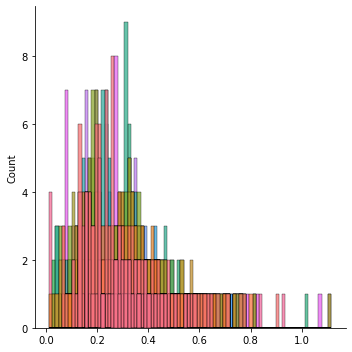

In [ ]:
import seaborn as sns
sns.displot(transformed.iloc[:, 1:], legend=False)

In [14]:
transformed['mouseID'] = (np.arange(len(transformed)) // 2) + 1
transformed['isMale'] =  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
transformed.head()

,AfterProbiotic,(12 or 13)-methylmyristate (a15:0 or i15:0),(14 or 15)-methylpalmitate (a17:0 or i17:0),(16 or 17)-methylstearate (a19:0 or i19:0),(3'-5')-adenylyladenosine*,(3'-5')-adenylylcytidine,(3'-5')-adenylyluridine,(3'-5')-cytidylylcytidine*,(3'-5')-cytidylylguanosine,(3'-5')-cytidylyluridine*,(3'-5')-guanylylcytidine,(3'-5')-guanylyluridine,(3'-5')-uridylylcytidine*,(3'-5')-uridylyluridine,(N(1) + N(8))-acetylspermidine,1-(1-enyl-oleoyl)-GPE (P-18:1)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*,1-(1-enyl-palmitoyl)-2-palmitoyl-GPC (P-16:0/16:0)*,1-(1-enyl-palmitoyl)-GPC (P-16:0)*,1-(1-enyl-palmitoyl)-GPE (P-16:0)*,1-(1-enyl-stearoyl)-2-arachidonoyl-GPE (P-18:0/20:4)*,1-(1-enyl-stearoyl)-GPE (P-18:0)*,1-(3-aminopropyl)-2-pyrrolidone,"1,2,3-benzenetriol sulfate (2)","1,2-dilinolenoyl-digalactosylglycerol (18:3/18:3)","1,2-dilinoleoyl-digalactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-galactosylglycerol (18:2/18:2)*","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,2-dipalmitoyl-GPE (16:0/16:0)*","1,2-dipalmitoyl-GPG (16:0/16:0)","1,5-anhydroglucitol (1,5-AG)",10-heptadecenoate (17:1n7),10-hydroxystearate,...,threonylphenylalanine,thymidine,thymine,tigloylglycine,thymidine 5'-monophosphate,trans-nonadecenoate (tr 19:1)*,trans-urocanate,tricarballylate,tricosanoyl sphingomyelin (d18:1/23:0)*,triethanolamine,trigonelline (N'-methylnicotinate),trimethylamine N-oxide,tryptamine,tryptophan,tryptophylglycine,tyramine,tyrosine,tyrosol,uridine 5'-monophosphate (UMP),undecanedioate (C11-DC),uracil,urate,urea,uridine,"uridine-2',3'-cyclic monophosphate",ursocholate,valerate (5:0),valerylglycine,valine,valylglutamine,valylglycine,valylleucine,vanillactate,vanillate,xanthine,xanthosine,xanthurenate,xylose,mouseID,isMale
0,0,0.225261,0.278679,0.281707,0.371699,0.296896,0.345170,0.327160,0.364861,0.315998,0.428007,0.229154,0.315282,0.303442,0.277109,0.578206,0.582864,0.476517,0.713411,0.125700,0.589582,0.318021,0.558861,0.627153,0.362124,0.427786,0.410821,0.411657,0.355112,0.564986,0.446845,0.523068,0.608036,0.556672,0.393110,0.349071,0.245571,0.287413,0.327426,0.261043,...,0.432405,0.341183,0.252818,0.410924,0.231824,0.146901,0.325772,0.404882,0.345753,0.388421,0.351922,0.112215,0.220971,0.465774,0.467020,0.100817,0.383989,0.128544,0.303937,0.264798,0.267422,0.281078,0.395760,0.404706,0.237145,0.268208,0.256353,0.387943,0.377456,0.390673,0.395586,0.350361,0.437855,0.425062,0.258874,0.308390,0.427909,0.329856,1,1
1,1,0.406144,0.326604,0.284223,0.152852,0.208371,0.156916,0.155098,0.255066,0.159247,0.132137,0.229154,0.153183,0.171271,0.254253,0.259322,0.301202,0.367009,0.307186,0.178241,0.284544,0.181953,0.234162,0.214915,0.314872,0.489560,0.317573,0.214602,0.061047,0.284781,0.303459,0.292961,0.283544,0.240259,0.324559,0.289405,0.161744,0.271201,0.393781,0.335731,...,0.204850,0.292032,0.368749,0.151436,0.237893,0.387078,0.265267,0.095855,0.310353,0.156381,0.148692,0.065062,0.298968,0.247532,0.159627,0.115261,0.269967,0.269075,0.198339,0.327530,0.281404,0.189649,0.009458,0.174767,0.113527,0.437611,0.255103,0.133316,0.248657,0.161503,0.190311,0.193483,0.156724,0.201721,0.289322,0.113600,0.231322,0.293315,1,1
2,0,0.279490,0.309543,0.280385,0.217024,0.208371,0.222842,0.220240,0.255066,0.236608,0.251867,0.229154,0.217498,0.243429,0.285260,0.396852,0.568063,0.330629,0.392852,0.125700,0.467345,0.211407,0.482135,0.425605,0.277266,0.297123,0.287136,0.337550,0.116497,0.398795,0.440831,0.464110,0.379348,0.367793,0.369537,0.294864,0.147048,0.222881,0.329371,0.303555,...,0.280900,0.309801,0.301498,0.322036,0.193398,0.158262,0.340352,0.278210,0.283717,0.359083,0.223901,0.073125,0.155408,0.324233,0.270047,0.058082,0.319762,0.127962

##**Linear Model Setup**##

In [15]:
! mkdir data

In [16]:
# For each biochemical, create a csv file with just that biochemical

for column in range(1, 824):
  df = transformed.iloc[:, [0, column, 824, 825]].copy()
  # change name of the biochem column to abundance
  df['abundance'] = df[df.columns[1]]
  df = df.drop(columns=[df.columns[1]])
  df.to_csv(cwd + "/data/%d.txt" % (column))

In [17]:
%load_ext rpy2.ipython

In [19]:
import rpy2.ipython.html
rpy2.ipython.html.init_printing()

In [20]:
! mkdir p_values

##**Model 1: dependent variable is metabolite; independent variable is time-point.**##



In [21]:
! mkdir p_values/m1

In [22]:
%%R
p_vals_m1 = data.frame(
   p_val = c(1:823)
)

In [23]:
%%R

get_p_val_m1 = function(data) {
    model = lm(abundance ~ AfterProbiotic, data=data, family=binomial)
    coef = coef(summary(model))[,4]
    # print(coef)
    p_val = coef[2]
    return (p_val)
}

In [24]:
%%R
d = read.csv(file=paste("/content/data/", 1, '.txt', sep=""))
get_p_val_m1(d)

AfterProbiotic 
     0.3639741 


In [25]:
%%R
for (id in 1:823) {
  data = read.csv(file= paste("/content/data/", id, '.txt', sep=""))
  p_val = tryCatch(
      get_p_val_m1(data),
      error=function(e) {return (1)}
  )
  p_vals_m1[id, 1] = p_val
}

In [26]:
%%R
head(p_vals_m1)

      p_val
1 0.3639741
2 0.8036024
3 0.9532519
4 0.1790773
5 0.2681103
6 0.1827886


In [27]:
%%R
write.csv(p_vals_m1, "p_values/m1/p_vals_time.csv")

##**Model 2: dependent variable is metabolite; independent variables are time-point and mouse sex.**##

In [28]:
! mkdir p_values/m2

In [29]:
%%R

p_vals_m2_time = data.frame(
   p_val = c(1:823)
)
p_vals_m2_sex = data.frame(
   p_val = c(1:823)
)

In [30]:
%%R

get_p_vals_m2 = function(data) {
    model = lm(abundance ~ AfterProbiotic + isMale, data=data, family=binomial)
    coef = coef(summary(model))[,4]
    p_val_time = coef[2]
    p_val_sex = coef[3]
    return (list(p_val_time, p_val_sex))
}

In [31]:
%%R
d = read.csv(file=paste("/content/data/", 1, '.txt', sep=""))
plist = get_p_vals_m2(d)
plist

[[1]]
AfterProbiotic 
      0.392945 

[[2]]
   isMale 
0.7055546 



In [32]:
%%R
for (id in 1:823) {
  data = read.csv(file= paste("/content/data/", id, '.txt', sep=""))
  p_val_list = tryCatch(
      get_p_vals_m2(data),
      error=function(e) {return (list(1, 1))}
  )
  p_vals_m2_time[id, 1] = p_val_list[1]
  p_vals_m2_sex[id, 1] = p_val_list[2]
}

In [33]:
%%R
head(p_vals_m2_time)

      p_val
1 0.3929450
2 0.8051632
3 0.9548207
4 0.2053015
5 0.2941020
6 0.2103863


In [34]:
%%R

head(p_vals_m2_sex)

      p_val
1 0.7055546
2 0.3633771
3 0.4870788
4 0.6739872
5 0.6231307
6 0.7108342


In [35]:
%%R

write.csv(p_vals_m2_time, "p_values/m2/p_vals_time.csv")
write.csv(p_vals_m2_sex, "p_values/m2/p_vals_sex.csv")

##**Model 3: dependent variable is metabolite; independent variables are time-point and mouse sex, and also control for mouseID as a random-effect (use 'lmer' function with (1|mouseID).**##

In [36]:
! mkdir p_values/m3

In [ ]:
%%R

install.packages("lmerTest")

In [37]:
%%R

p_vals_m3_time = data.frame(
   p_val = c(1:823)
)
p_vals_m3_sex = data.frame(
   p_val = c(1:823)
)

In [79]:
%%R

library(lmerTest)
get_p_vals_m3 = function(data) {
    model = lmer(abundance ~ AfterProbiotic + isMale + (1|mouseID), data=data)
    coef = coef(summary(model))[,5]
    p_val_time = coef[2]
    p_val_sex = coef[3]
    return (list(p_val_time, p_val_sex))
}

In [80]:
%%R
d = read.csv(file=paste("/content/data/", 1, '.txt', sep=""))
get_p_vals_m3(d)

R[write to console]: boundary (singular) fit: see ?isSingular



[[1]]
AfterProbiotic 
      0.392945 

[[2]]
   isMale 
0.7055546 



In [ ]:
%%R
for (id in 1:823) {
  data = read.csv(file= paste("/content/data/", id, '.txt', sep=""))
  p_val_list = tryCatch(
      get_p_vals_m3(data),
      error=function(e) {return (list(1, 1))}
  )
  p_vals_m3_time[id, 1] = p_val_list[1]
  p_vals_m3_sex[id, 1] = p_val_list[2]
}

In [82]:
%%R 

head(p_vals_m3_time)

      p_val
1 0.3929450
2 0.7517336
3 0.9469909
4 0.1373531
5 0.0367927
6 0.1270321


In [83]:
%%R

head(p_vals_m3_sex)

      p_val
1 0.7055546
2 0.4945588
3 0.5811248
4 0.7498303
5 0.7493047
6 0.7831209


In [84]:
%%R

write.csv(p_vals_m3_time, "p_values/m3/p_vals_time.csv")
write.csv(p_vals_m3_sex, "p_values/m3/p_vals_sex.csv")

##**Analysis**##

In [119]:
from statsmodels.stats.multitest import fdrcorrection

def correct(df):
  """
  Returns a dataframe with the pvals in the 1th column of df corrected for fdr
  """
  corrected = fdrcorrection(df.iloc[:, 1])[1]
  newdf = df.copy()
  newdf.iloc[:, 1] = corrected
  return newdf

Model 1

In [101]:
p_vals_m1_time = pd.read_csv('p_values/m1/p_vals_time.csv')

In [121]:
p_vals_m1_time.nsmallest(5, 'p_val')

,Unnamed: 0,p_val
535,536,0.000530
193,194,0.000721
411,412,0.000814
182,183,0.000948
670,671,0.001283


In [114]:
correct(p_vals_m1_time).nsmallest(5, 'p_val')

,Unnamed: 0,p_val
182,183,0.156005
193,194,0.156005
235,236,0.156005
271,272,0.156005
344,345,0.156005


Model 2

In [103]:
p_vals_m2_time = pd.read_csv('p_values/m2/p_vals_time.csv')
p_vals_m2_sex = pd.read_csv('p_values/m2/p_vals_sex.csv')

In [123]:
p_vals_m2_time.nsmallest(5, 'p_val')

,Unnamed: 0,p_val
739,740,0.000020
143,144,0.000098
535,536,0.000280
382,383,0.000321
701,702,0.000485


In [115]:
correct(p_vals_m2_time).nsmallest(5, 'p_val')

,Unnamed: 0,p_val
739,740,0.016325
143,144,0.040428
44,45,0.062533
164,165,0.062533
182,183,0.062533


In [105]:
p_vals_m2_sex.nsmallest(5, 'p_val')

,Unnamed: 0,p_val
384,385,0.000003
37,38,0.000041
543,544,0.000173
739,740,0.000209
143,144,0.000387


In [116]:
correct(p_vals_m2_sex).nsmallest(5, 'p_val')

,Unnamed: 0,p_val
384,385,0.002341
37,38,0.017051
543,544,0.043007
739,740,0.043007
143,144,0.054256


Model 3

In [106]:
p_vals_m3_time = pd.read_csv('p_values/m3/p_vals_time.csv')
p_vals_m3_sex = pd.read_csv('p_values/m3/p_vals_sex.csv')

In [107]:
p_vals_m3_time.nsmallest(5, 'p_val')

,Unnamed: 0,p_val
739,740,0.000020
143,144,0.000144
535,536,0.000280
382,383,0.000321
701,702,0.000485


In [117]:
correct(p_vals_m3_time).nsmallest(5, 'p_val')

,Unnamed: 0,p_val
739,740,0.016325
143,144,0.059052
382,383,0.065986
535,536,0.065986
670,671,0.071221


In [108]:
p_vals_m3_sex.nsmallest(5, 'p_val')

,Unnamed: 0,p_val
384,385,0.000003
37,38,0.000041
543,544,0.000173
739,740,0.000209
382,383,0.000494


In [118]:
correct(p_vals_m3_sex).nsmallest(5, 'p_val')

,Unnamed: 0,p_val
384,385,0.002341
37,38,0.017051
543,544,0.043007
739,740,0.043007
330,331,0.061038
